<a href="https://colab.research.google.com/github/wgrzyb/PJN_L3/blob/main/PJN_L3_LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zadanie laboratoryjne nr 3 - LSA

Wykonał: Wojciech Grzyb

Grupa: WCY19KB2S4

---

1. Utworzyć korpus wybranych dokumentów tekstowych (co najmniej 7 dokumentów), pochodzących z 3 różnych działów (np. ekonomia, sport, polityka, motoroyzacja etc.
2. Zbudować macierz DTM (Document Term Matrix) wykorzystując formy podstawowe słów.
3. Wyodrębnić koncepty  z wykorzystaniem SVD:



*   wyznaczyć macierze U, S, V.
*   przedstawić w postaci chmury tagów słowa należące do każdego tematu (wielkość słowa powinna odpowiadać sile związku słowa z tematem)
*   przedstawić w postaci wykresu radarowego tematy każdego z dokumentów


---

1) Przygotowanie korpusu dokumentów:

In [1]:
import requests

political_articles = ['https://pastebin.pl/view/raw/ece8580e','https://pastebin.pl/view/raw/44a3b706']
motorization_articles = ['https://pastebin.pl/view/raw/2a98ba2f', 'https://pastebin.pl/view/raw/178ca72d', 'https://pastebin.pl/view/raw/74659fed']
sport_articles = ['https://pastebin.pl/view/raw/9f74daab', 'https://pastebin.pl/view/raw/f54f0750']

corpus = [('political_articles', political_articles), 
          ('motorization_articles', motorization_articles), 
          ('sport_articles', sport_articles)
          ]

# Pobranie artykułów
articles = []
for pos in corpus:
  category = pos[0]
  category_articles = pos[1]
  for category_article in category_articles:
    r = requests.get(category_article)
    articles.append(r.text)

# Wypisanie kategorii artykułów:
print('Korpus:')
for pos in corpus:
  print(f' * {pos[0]}: {len(pos[1])}')


Korpus:
 * political_articles: 2
 * motorization_articles: 3
 * sport_articles: 2


2) Budowa macierzy DTM wykorzystując formy podstawowe słów:

In [2]:
#@title Przygotowanie środowiska
%%capture
# Instalacja Morfeusza 2
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install morfeusz2
!sudo apt install python3-morfeusz2

# Instalacja spaCy
!python3 -m pip install spacy

# Instalacja modelu IPI PAN dla języka polskiego
!wget "http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz"
!mv 'SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz' pl_spacy_model_morfeusz-0.1.3.tar.gz
!python3 -m pip install pl_spacy_model_morfeusz-0.1.3.tar.gz

# Linkowanie modelu do spaCy
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz -f

# Dodatkowe zależności:
!python3 -m pip install tqdm
!python3 -m pip install networkx


In [3]:
import nltk
import numpy as np
import pandas as pd
import spacy

nlp = spacy.load("pl_spacy_model_morfeusz")  # Załadowanie modelu IPI PAN

# Załadowanie stoplisty dla języka polskiego
r = requests.get('https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt')
stop_words = r.text.splitlines()

# Utworzenie obiektów klasy Doc dla każdego artykułu z korpusu
doc_list = []
for i in range(len(articles)):
  doc = nlp(articles[i])  # Utworzenie obiektu klasy Doc (obiektu przechowującego tokeny artykułu)
  doc_list.append(doc)  # Dodanie utworzonego obiektu do listy

# Utworzenie słownika term-ów (słów sporwadzonych do formy podstawowej) wraz z ilością ich występowania
terms_dict = {}
for doc in doc_list:
  for token in doc:
    if token.lemma_ not in terms_dict:
      terms_dict[token.lemma_] = 1
    else:
      terms_dict[token.lemma_] += 1

# Utworzenie listy term-ów, które występują więcej niż 1 raz oraz nie znajdują się w stopliście
terms = [term for term in terms_dict if terms_dict[term] > 1 and term not in stop_words ]

# Utworzenie macierzy DTM
dtm = np.zeros((len(doc_list), len(terms)), dtype=int)
for i in range(len(doc_list)):
  for token in doc_list[i]:
    if token.lemma_ in terms:
      dtm[i][terms.index(token.lemma_)] += 1

# Wizualizacja zbudowanej macierzy za pomocą pandas.DataFrame
article_names = [f"article {i+1}" for i in range(len(doc_list))]
article_df = pd.DataFrame(data = article_names, columns = ['article'])  # Kolumna z nazwami artykułów
dtm_df = pd.DataFrame(dtm, columns=terms)
final_dtm_df = pd.concat([article_df, dtm_df], axis = 1)
print(final_dtm_df)


     article  prawo  sprawiedliwość  ...  zabójstwo  morderstwo  późno
0  article 1      1               1  ...          0           0      0
1  article 2      1               1  ...          0           0      0
2  article 3      0               0  ...          0           0      0
3  article 4      1               0  ...          0           0      0
4  article 5      0               0  ...          0           0      0
5  article 6      0               0  ...          0           0      0
6  article 7      0               0  ...          2           2      2

[7 rows x 417 columns]


3) Wyodrębnienie konceptów z wykorzystaniem SVD

In [4]:
# Wyznaczanie macierzy U, S, V dla macierzy: {dtm}
U, s, V = np.linalg.svd(dtm)
S = np.zeros((dtm.shape[0], dtm.shape[1]))
for i in range(min(dtm.shape[0], dtm.shape[1])):
  S[i, i] = s[i]

# Weryfikacja wyznaczonych macierzy
if not np.allclose(dtm, U@S@V):
  raise Exception('Błędnie wyznaczono macierze U, S, V')

# Wypisanie wyznaczonych macierzy
print(f"U:\n{U}")
print(f"S:\n{S}")
print(f"V:\n{V}")


U:
[[-0.20152028  0.36297983  0.13428332 -0.85782222  0.26388261 -0.05893577
  -0.02523486]
 [-0.24574492 -0.03207611  0.37966786  0.28620995  0.43499229 -0.72281219
   0.02899958]
 [-0.26874667  0.36070336 -0.21156125 -0.00880162 -0.72565536 -0.4748033
   0.02861492]
 [-0.21329843  0.40240665 -0.39906853  0.26290119  0.29880792  0.10162206
  -0.68160599]
 [-0.19244029  0.39044594 -0.3505216   0.21359773  0.29289584  0.15410406
   0.72972138]
 [-0.32224226  0.35302075  0.69467499  0.24403396 -0.19687949  0.43593706
  -0.02465174]
 [-0.80025289 -0.54599181 -0.16842719 -0.08862191 -0.02713481  0.15657174
   0.0039615 ]]
S:
[[161.96035056   0.           0.         ...   0.           0.
    0.        ]
 [  0.          44.18905243   0.         ...   0.           0.
    0.        ]
 [  0.           0.          36.54997149 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0. 

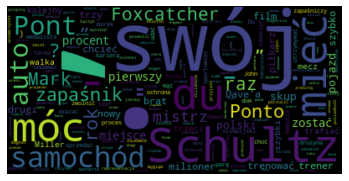

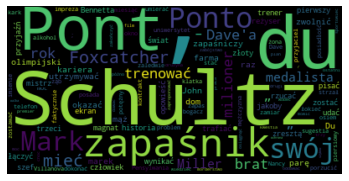

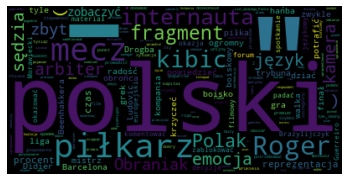

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud

n_components = 3
# Z dokumentacji funkcji TruncatedSVD:
# n_components int, default = 2; Desired dimensionality of output data. Must be strictly less than the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended.
# stąd liczba wyróżnionych konceptów (tematów) za pomocą funkcji TruncatedSVD będzie zawsze równa: min(n_components, dtm.shape[0])
n_topics = min(n_components, dtm.shape[0])
if n_components != n_topics:
  print(f'Ograniczenie tematów do: {n_topics}')
# Ograniczenie tematów do: {n_topics}
svd = TruncatedSVD(n_components=n_topics)
U = svd.fit_transform(dtm_df)
Vt = svd.components_

# Wizualizacja każdego tematu za pomocą chmury tagów
for concept in Vt:
  wordcloud_tags = {}
  for i in range(len(concept)):
    wordcloud_tags[terms[i]] = concept[i]
  # Wygenerowanie chmury tagów
  wordcloud = WordCloud().generate_from_frequencies(wordcloud_tags)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()


[ 32.63829511 -16.03973478   4.90805157]


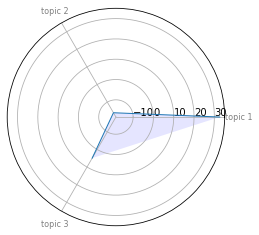

[39.80093408  1.41741303 13.87684929]


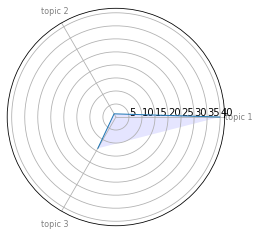

[ 43.52630467 -15.93913981  -7.73255767]


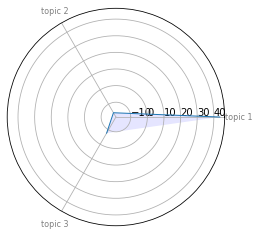

[ 34.54588792 -17.78196869 -14.58594344]


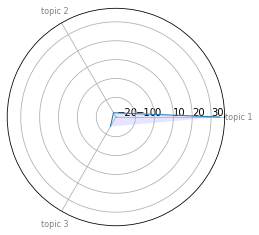

[ 31.16769634 -17.25343597 -12.81155466]


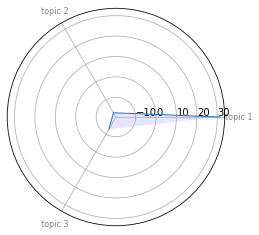

[ 52.1904692  -15.59965247  25.39035099]


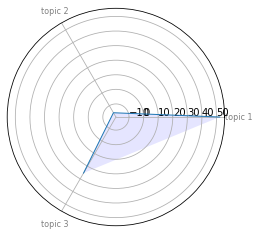

[129.60923791  24.12686065  -6.15600917]


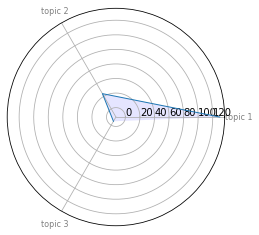

In [6]:
from math import pi

# Przedstawienie w postaci wykresu radarowego tematów każdego z artykułów
for article in U:
  # Określenie listy tematów
  categories=[f"topic {i+1}" for i in range(n_topics)] 
  # Wyznaczenie kąta na wykresie radarowym
  angles = [n / float(n_topics) * 2 * pi for n in range(n_topics)]
  # Zainicjalizowanie: spider plot
  ax = plt.subplot(111, polar=True)
  # Rysowanie wykresu:
  plt.xticks(angles, categories, color='grey', size=8)
  ax.set_rlabel_position(0)
  # Naniesienie danych na wykres
  print(article)
  ax.plot(angles, article, linewidth=1, linestyle='solid')
  ax.fill(angles, article, 'b', alpha=0.1)
  plt.show()


4)* Wyodrębnienie konceptów z wykorzystaniem SVD (dla innej wartości parametru n_components w celu porównania wyników)

Ograniczenie tematów do: 7


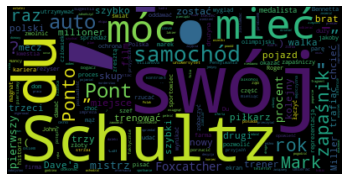

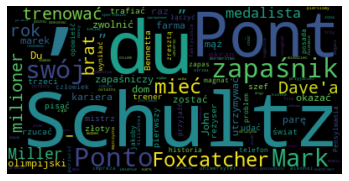

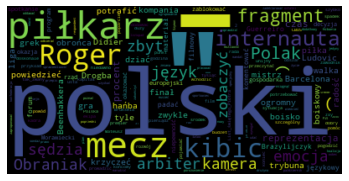

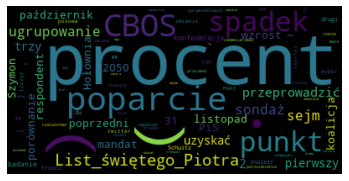

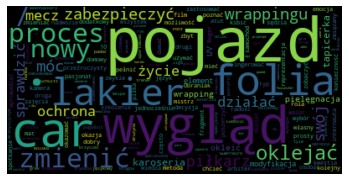

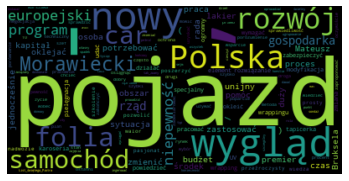

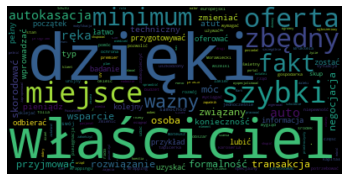

[ 32.63829511 -16.03973478   4.90805157  24.96326139  -5.80106738
   1.21591743  -0.29047106]


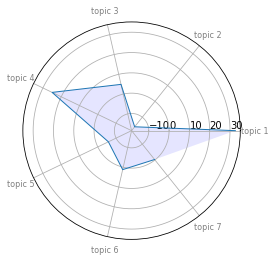

[39.80093408  1.41741303 13.87684929 -8.32892144 -9.56265975 14.9125055
  0.33380559]


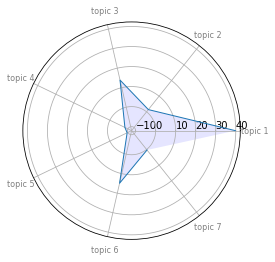

[ 43.52630467 -15.93913981  -7.73255767   0.25613358  15.95245567
   9.79577663   0.32937793]


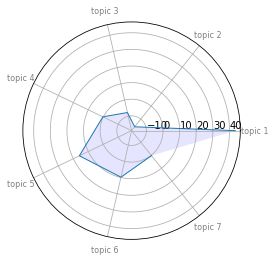

[ 34.54588792 -17.78196869 -14.58594344  -7.65061917  -6.56884846
  -2.09658821  -7.84576608]


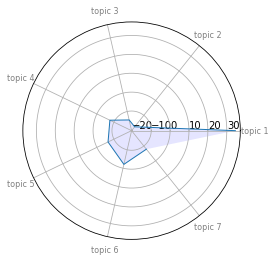

[ 31.16769634 -17.25343597 -12.81155466  -6.21585197  -6.43888028
  -3.17935639   8.39960815]


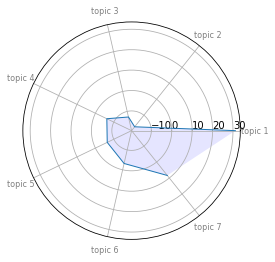

[ 52.1904692  -15.59965247  25.39035099  -7.1015688    4.32810339
  -8.9939183   -0.28375893]


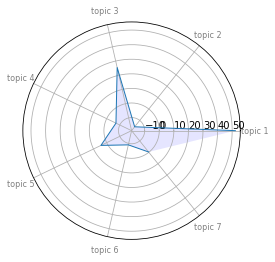

[ 1.29609238e+02  2.41268607e+01 -6.15600917e+00  2.57896308e+00
  5.96518552e-01 -3.23026779e+00  4.55996231e-02]


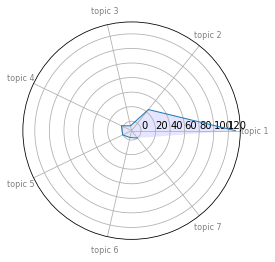

In [7]:
n_components = 10
# Z dokumentacji funkcji TruncatedSVD:
# n_components int, default = 2; Desired dimensionality of output data. Must be strictly less than the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended.
# stąd liczba wyróżnionych konceptów (tematów) za pomocą funkcji TruncatedSVD będzie zawsze równa: min(n_components, dtm.shape[0])
n_topics = min(n_components, dtm.shape[0])
if n_components != n_topics:
  print(f'Ograniczenie tematów do: {n_topics}')
# Ograniczenie tematów do: {n_topics}
svd = TruncatedSVD(n_components=n_topics)
U = svd.fit_transform(dtm_df)
Vt = svd.components_

# Wizualizacja każdego tematu za pomocą chmury tagów
for concept in Vt:
  wordcloud_tags = {}
  for i in range(len(concept)):
    wordcloud_tags[terms[i]] = concept[i]
  # Wygenerowanie chmury tagów
  wordcloud = WordCloud().generate_from_frequencies(wordcloud_tags)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

# Przedstawienie w postaci wykresu radarowego tematów każdego z artykułów
for article in U:
  # Określenie listy tematów
  categories=[f"topic {i+1}" for i in range(n_topics)] 
  # Wyznaczenie kąta na wykresie radarowym
  angles = [n / float(n_topics) * 2 * pi for n in range(n_topics)]
  # Zainicjalizowanie: spider plot
  ax = plt.subplot(111, polar=True)
  # Rysowanie wykresu:
  plt.xticks(angles, categories, color='grey', size=8)
  ax.set_rlabel_position(0)
  # Naniesienie danych na wykres
  print(article)
  ax.plot(angles, article, linewidth=1, linestyle='solid')
  ax.fill(angles, article, 'b', alpha=0.1)
  plt.show()
